In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as sps
import pandas as pd
import cupy as cp
from scipy.stats import norm, chi2
%matplotlib widget

from scipy.constants import h, c, k


# Plotting format for thesis
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', titlesize=16, labelsize=16)
plt.rc('legend', fontsize=14)
plt.rc('figure', titlesize=18)

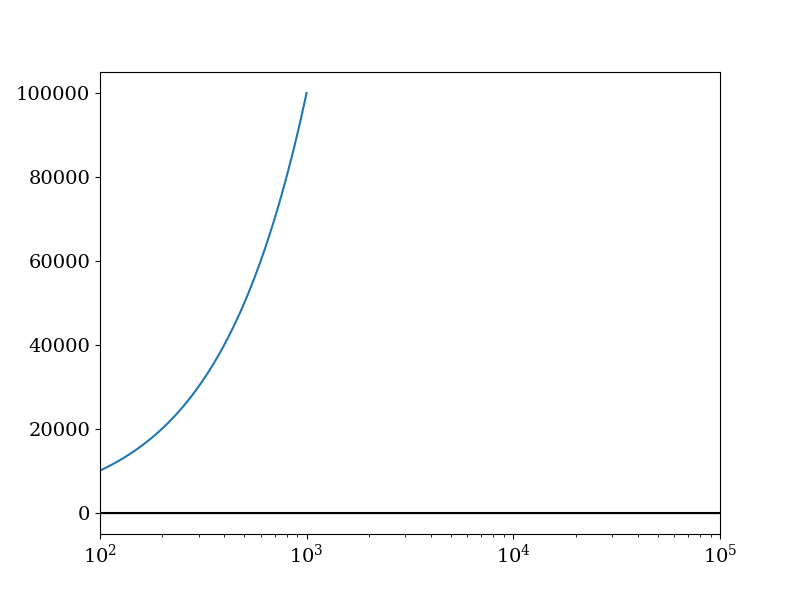

In [21]:
#first attempt at remaking John's plot

# Generate data 
time = np.linspace(100, 1e5, 1000)

deltaNu = 50 #Hz
signalPow = 1e-24 #W
noise = 3.9e-22 #W


#signal = 10 / np.sqrt(time)
#uncertainty = signal   

# Plotting
plt.figure(figsize=(8, 6))

# Plot the main signal
plt.plot(time,np.repeat(signalPow,len(time)), 'black', label='Signal')

# Plot the uncertainty as a shaded area
plt.fill_between(time, signalPow *(1+ 1/np.sqrt(time*deltaNu)),  signalPow*(1 - 1/np.sqrt(time*deltaNu)), color='gray', alpha=0.5)

plt.plot(time, )
'''
# Plot the uncertainty as a shaded area
plt.fill_between(time, 10- uncertainty, 10 + uncertainty, color='gray', alpha=0.5)

# Add a horizontal line at y=10
plt.axhline(y=10, color='k')

# Add a vertical dashed line at x=1000 and highlight the range 900-1100
plt.axvline(x=1000, color='k', linestyle='--')
plt.axvspan(900, 1100, color='red', alpha=0.3)

# Set scale and labels
plt.xscale('log')
plt.ylim(0, 20)
plt.xlabel('Time')
plt.ylabel('Measured Signal (mV)')
'''
plt.xlim(1e2,1e5)
plt.semilogx()
plt.show()
